In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,12)


In [9]:
LOW_THRESHOLD_CANNY = 100
HIGH_THRESHOLD_CANNY = 200

The iPython notebook for [Finding Lane Lines on the Road](https://github.com/udacity/CarND-LaneLines-P1). The images need to reside in `test_images/` folder, whereas the video input resides in the current directory.

In [10]:
def define_vertices(img):
    imshape = img.shape
    vertices = np.array([[(0,imshape[0]), (imshape[1]/2., imshape[0]/2.), (imshape[1],imshape[0])]], dtype=np.int32)
    if vertices.shape[1]:
        vertices = [vertices]
    return vertices

def show_image_transformations(image, masked_image, lines, w_image):
    plt.subplot(221),plt.imshow(image,aspect='auto')
    plt.title('Grey Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(222),plt.imshow(masked_image, aspect='auto')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(223),plt.imshow(lines,cmap = 'gray', aspect='auto')
    plt.title('Line Image'), plt.xticks([])
    plt.subplot(224),plt.imshow(w_image,cmap = 'gray', aspect='auto')
    plt.title('Weighted Image'), plt.xticks([])

In [15]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    #return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size=7):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=1):
    """
    Take lines as given. Next iteration goes throug some heuristics to merge the lines. 
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines_image(img, rho=1, theta=np.pi/90, threshold=30, min_line_len=25, max_line_gap=10):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def hough_lines(img, rho=1, theta=np.pi/90, threshold=30, min_line_len=25, max_line_gap=10):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)



## Lane Detection on Images

My approach here is to minize false positives when it comes to detecting the dashed white lanes. Because the shorter dashed white lanes are practically indistinguishable from any white object in the image, I decided to detect the longer dashed lines, which is sufficient to extrapolate to construct the corridor the car is driving in.

The parameters for Hough line detection and Canny edge algorithm are hand-tuned based on the accuracy of the test images. A better approach would have been to learn them if I had some labeled data. 

I first apply some Gaussian filter to smooth out the image. Next, I detect the edges in the image and mask the regions that are not relevant for the exercise. The relevant region of the image is the triangle-shaped slice that connects lower corners to the middle of the image. Taking in the masked edges as an input, the Hough filter gives me bunch of lines, which I flatten to bunch of points with `fit_lanes`. I use the points, in turn, to fit a linear regression - two regression to be precise to retrieve the line on the left and right sides of the viewpoint. Linear regression is robust enough to discard the outliers. Outliers are large patches in the images that are caught by edge detection and Hough transofrmation. A white car for example might have significant contrast with respect to its surroundings and be large enough in the image to fool the line detection logic. Regression tries to overcome such outliers. 

In all, `fit_lanes` method takes the lines coming from the Hough transformation and outputs points in the image that identifies the lanes. 

In [16]:
def fit_lanes(lines, image_shape):
    # determine the mid point
    mid_point = image_shape[1]/2
    
    left_xs = np.arange(0, mid_point, 1).reshape(-1,1)
    right_xs = np.arange(mid_point, image_shape[1], 1).reshape(-1,1)
    # flatten the lines to the points (x1,y1, x2, y2) -> (x1,y1), (x2,y2)
    lines_df = pd.DataFrame([l[0] for l in lines])
    a_, b_ = lines_df.ix[:,2:], lines_df.ix[:,:1]
    a_.columns = b_.columns
    points = np.array(pd.concat([a_,b_]))
    # linear regression for left and right space
    left_points = np.array(list(filter(lambda x: x[0] < mid_point, points )))
    right_points = np.array(list(filter(lambda x: x[0] >= mid_point, points )))
    lr_left, lr_right = LinearRegression(), LinearRegression()
    lr_right.fit(right_points[:,0].reshape(-1,1), right_points[:,1].reshape(-1,1))
    lr_left.fit(left_points[:,0].reshape(-1,1), left_points[:,1].reshape(-1,1))
    # prediction for left and right space
    left_ys = lr_left.predict(left_xs).reshape(-1,)
    right_ys = lr_right.predict(right_xs).reshape(-1,)
    left_xs = left_xs.reshape(-1,)
    right_xs = right_xs.reshape(-1,)
    # trim ys
    points_left = np.array(list(filter(lambda p: p[1] < image_shape[0], zip(left_xs,left_ys))))
    points_right = np.array(list(filter(lambda p: p[1] < image_shape[0], zip(right_xs,right_ys))))
    return points_left, points_right

def retrieve_min_max_points(left, right):
    l = {}
    l['x1'], l['y2'] = int(left[:,0].min()), int(left[:,1].min())   
    l['x2'], l['y1'] = int(left[:,0].max()), int(left[:,1].max())

    r = {}
    r['x1'], r['y1'] = int(right[:,0].min()), int(right[:,1].min())   
    r['x2'], r['y2'] = int(right[:,0].max()), int(right[:,1].max())

    return l, r

def draw_lanes(image, lines, color= [255, 0, 0], thickness=10):
    image_shape  = image.shape
    points_left, points_right = fit_lanes(lines, image_shape)
    l, r = retrieve_min_max_points(points_left, points_right)
    line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    cv2.line(line_img, (l['x1'], l['y1']), (l['x2'], l['y2']), color, thickness)
    cv2.line(line_img, (r['x1'], r['y1']), (r['x2'], r['y2']), color, thickness)
    return line_img
    

# Pipeline

Now we put it all together. `detect_lanes` processes a single image and returns the weighted image. We then persist the modified image. 

In [17]:
def process_image(orig_image):
    image = grayscale(orig_image)
    # Smoothing
    image = gaussian_blur(image)
    # Edge Detection
    image_edges = canny(image,LOW_THRESHOLD_CANNY, HIGH_THRESHOLD_CANNY)
    # Mask Image
    vertices = define_vertices(image_edges)
    masked_image = region_of_interest(image_edges, vertices)
    # Find the Lines
    lines = hough_lines(masked_image)
    # Fit the Lanes
    line_image = draw_lanes(image, lines)
    # return Weighted Image
    wi = weighted_img(orig_image, line_image )
    return wi

def save_processed_image(img_name):
    img = cv2.imread(img_name)
    wi = process_image(img)
    cv2.imwrite(img_name + "_processed.jpg", wi)
    print("Image {} saved".format(img_name))

# Detecting Lanes for Test Images

We apply the `process_image` method onto the test images and save the processed images to disk. 

solidWhiteCurve.jpg
solidWhiteCurve.jpg_processed.jpg
solidWhiteCurve.jpg_processed.jpg_processed.jpg
solidWhiteCurve.jpg_processed.jpg_processed.jpg_processed.jpg
solidWhiteCurve.jpg_processed.jpg_processed.jpg_processed.jpg_processed.jpg
solidWhiteRight.jpg
solidWhiteRight.jpg_processed.jpg
solidWhiteRight.jpg_processed.jpg_processed.jpg
solidYellowCurve.jpg
solidYellowCurve.jpg_processed.jpg
solidYellowCurve.jpg_processed.jpg_processed.jpg
solidYellowCurve2.jpg
solidYellowCurve2.jpg_processed.jpg
solidYellowCurve2.jpg_processed.jpg_processed.jpg
solidYellowLeft.jpg
solidYellowLeft.jpg_processed.jpg
solidYellowLeft.jpg_processed.jpg_processed.jpg
whiteCarLaneSwitch.jpg
whiteCarLaneSwitch.jpg_processed.jpg
whiteCarLaneSwitch.jpg_processed.jpg_processed.jpg


(<matplotlib.axes._subplots.AxesSubplot at 0x7fd83ff86278>,
 <matplotlib.image.AxesImage at 0x7fd83fe9b7b8>)

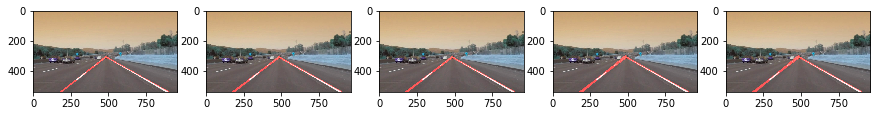

In [18]:
image_names = os.listdir("test_images/")
processed_images = []
for image_name in image_names:
    print(image_name)
    image = cv2.imread("test_images/"+ image_name)
    wi = process_image(image)
    processed_images.append(wi)
    output_path = "test_images/" + image_name + "_processed.jpg"
    cv2.imwrite(output_path, wi)

plt.subplot(151),plt.imshow(processed_images[0],cmap = 'gray')
plt.subplot(152),plt.imshow(processed_images[1],cmap = 'gray')
plt.subplot(153),plt.imshow(processed_images[2],cmap = 'gray')
plt.subplot(154),plt.imshow(processed_images[3],cmap = 'gray')
plt.subplot(155),plt.imshow(processed_images[4],cmap = 'gray')

# Detecting Lanes in the Video Feed

Wrapping the image processor with a try/catch block.

In [19]:
def wrap(img):
    try:
        return process_image(img)
    except:
        return img

In [20]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [21]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(wrap)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:08<00:00, 27.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.82 s, sys: 350 ms, total: 4.17 s
Wall time: 9.1 s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [23]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(wrap)
%time yellow_clip.write_videofile(yellow_output, audio=False)


[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:35<00:00, 18.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 15.2 s, sys: 1.33 s, total: 16.5 s
Wall time: 36.4 s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

# Challenge

The pipeline holds itself well to the curvate of the road and the white car we are passing by. One way to make the pipeline more robust to the curvature would be to extend the regression framework in a multi-frame setting. If we can detect the curvate by comparing two or more subsequent images, I believe we can fit the line better through some temporal smoothing.

In [25]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
clip2.save_frame("test_images/challenge.jpg")

(<matplotlib.axes._subplots.AxesSubplot at 0x7fd8378dc668>,
 <matplotlib.image.AxesImage at 0x7fd83789ae10>)

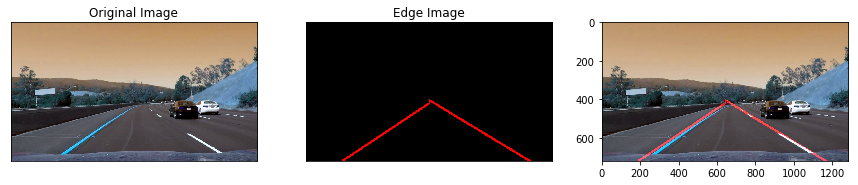

In [26]:
orig_image = cv2.imread("test_images/challenge.jpg")
image = grayscale(orig_image)
# Smoothing
image = gaussian_blur(image)
# Edge Detection
image_edges = canny(image,LOW_THRESHOLD_CANNY, HIGH_THRESHOLD_CANNY)
# Mask Image
vertices = define_vertices(image_edges)
masked_image = region_of_interest(image_edges, vertices)
# Find the Lines
lines = hough_lines(masked_image)
# Fit the Lanes
line_image = draw_lanes(image, lines)
# return Weighted Image
wi = weighted_img(orig_image, line_image )


plt.subplot(131),plt.imshow(orig_image,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(line_image,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(wi,cmap = 'gray')



In [27]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(wrap)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:25<00:00,  5.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 8.66 s, sys: 850 ms, total: 9.51 s
Wall time: 30.1 s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

# Reflections

The trick that made the lane detection work was to apply a linear regression to the data points emitted by the Hough transform. Particularly, Hough transform outputs lines defined by two points. These points were used to fit a linear regression on both side of the viewpoint -left and right- to create the line segments. The parameters for the pipeline -canny thresholds, hough parameters- are hand-tuned to eliminate the false-positives like white cars or patches in the image that have a sharp contrast with their immediate surroundings. I also used masking to focus only on the relevant part of the image. 

Although the simple pipeline works well, the curvature of the road can be taken into account better through some temporal smoothing. 